In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Model calibration part I - reliability assessment

This section is all about estimating the **score function**
$$\boxed{f(x) = \mathbb P (Y=1|X=x)}$$

which, as we know, really generates everything in binary classification. This is our main object of interest.

Recall that one can obtain binary predictions from a score $f$ by choosing a threshold $\lambda$:

$$\hat{y}(x) = \begin{cases}
1 & \mbox{if } f(x) \geq \lambda \\
0 & \mbox{if } f(x) < \lambda
\end{cases}
$$

Now, forget that we know that $f$ is a probability and let us take the definition of $\hat y(x)$ above as-is, for any real-valued function $f$. It still makes sense: for big values of $f(x)$ it spits out a 1, and for small values it returns a 0. 

In fact, **most machine learning algorithms don't estimate the score** $\mathbb P (Y=1|X=x)$. They just calculate a new function, say $g$, which approximates $\mathbb P$, in the sense that 

$$g(x) = \mathbb{\widehat P}(Y=1|X=x)$$

from which one can create rules exactly like before:

$$\hat y(x) = \begin{cases}
1 & \mbox{if } \hat g(x) \geq \lambda \\
0 & \mbox{if } \hat g(x) < \lambda
\end{cases}
$$

In fact, $g$ does not even need to be bound to $[0,1]$ (but we can suppose it is, with no loss of generality; were it not, we would just need to normalize it).

**Is $g$ a probability?** No, not necessarily. But why?

### When scores are not probabilities

For some arbitrary random variable $Z$, What does $\mathbb P (Z<40) = 0.2$ mean?

An interesting way to characterize this is via simulation. Let $Z_1, Z_2, \ldots, Z_n$ be $n$ iid copies of $Z$. If we measure all the $Z_i$'s, and build a histogram, what the statement $\mathbb P (Z<40) = 0.2$ really means is that *about 20% of the samples will have values lesser than 40*.

This same reasoning can be applied to the score function.

### Why would you want probabilities anyway?

In some cases, you don't. If all you care about is getting a model and predicting 1's and 0's, it doesn't need to be calibrated.

But in some cases you do. A classical example is in credit. Say you are a bank, and John wishes to get a loan from you. You need to define an interest rate $r$ to be applied to the loan.

Suppose John's actual probability of defaulting on the payment is $p$. If you lend him $L$ dollars, this means that:
* With probability $p$, you lose all your money; your profit is $-L$;
* With probability $1-p$, he pays it all back with interest; your profit is $+rL$

Your expected percent return is 

$$\frac{\mathbb E[\mathrm{profit}]}{L} = \frac{- p L + (1-p) r L}{L} = -p + r(1-p)$$

Further assume your bank wants to have an expected return on this loan of $\alpha$ (eg. 5%), that is

$$-p+r(1-p) \geq \alpha \quad \Rightarrow \quad r \geq \frac{\alpha+p}{1-p}$$

Suppose $p = 0.01$ and $\alpha = 0.05$. This implies $r \geq 6\%$ is an adequate interest to apply to the loan.

**But suppose our model is badly calibrated**. Then $p$ could have been taken to be 0.05, for example, and the interest would be more than 10%!

> **Conclusion: models need to be well-calibrated when the actual probabilities will be used, and not only the model binary predictions or their ranking!**

## A first glance at model reliability

Create a sample dataset, in which we will train 3 different models: gradient boosted trees, random forest, and a good old logistic regression.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [3]:
gb = HistGradientBoostingClassifier(max_depth=5, random_state=1)
rf = RandomForestClassifier(max_depth=5, random_state=2)
lr = LogisticRegression()

gb.fit(X_train, y_train);
rf.fit(X_train, y_train);
lr.fit(X_train, y_train);

For each of the models, let's plot their test set performances:

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [5]:
def compare_models(model_list, X_test, y_test):
    fig, ax = plt.subplots(figsize=(12,6), ncols=2)
    for model in model_list:

        model_name = type(model).__name__

        y_probs = model.predict_proba(X_test)[:,1]

        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc = roc_auc_score(y_test, y_probs)

        # PR
        prec, rec, _ = precision_recall_curve(y_test, y_probs)
        ap = average_precision_score(y_test, y_probs)

        # plot
        ax[0].plot(fpr, tpr, label=model_name + " (AUC={0:.2f})".format(auc))
        ax[1].plot(rec, prec, label=model_name + " (AP={0:.2f})".format(ap))

    ax[0].legend(); ax[1].legend()
    ax[0].plot([0,1], linestyle='--', color='gray')
    ax[0].set_title("ROC curves"); ax[1].set_title("Precision-Recall curves")

    plt.tight_layout()

    plt.show()

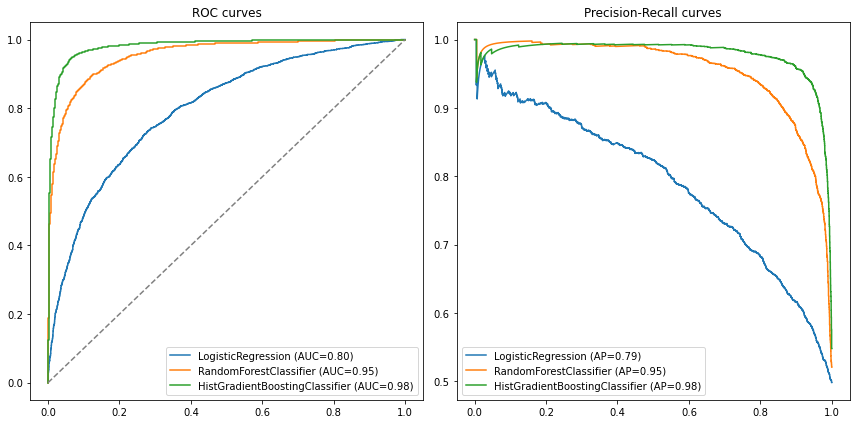

In [6]:
compare_models(model_list=[lr, rf, gb], X_test=X_test, y_test=y_test)

We can also just write the results into a table:

|Model|AUC|AP|
|---|---|---|
|Logistic regression|.80|.79|
|Random forest|.95|.95|
|Gradient boosting|.98|.98|

We see that the gradient boosted model outperforms the other two in both metrics.

The question is, then, **how do these models compare regarding how well they predict actual probabilities?**

# Calibration curves (aka reliability diagrams)

Let's take the logistic regression model as an example. We predict its scores for all elements in the test set, and sort our data from low to high scores:

In [7]:
y_probs = lr.predict_proba(X_test)[:,1]

In [8]:
predictions = pd.DataFrame({
    'label': y_test,
    'scores': y_probs,
})

In [9]:
predictions.head()

,label,scores
0,0,0.740110
1,0,0.648457
2,1,0.524043
3,1,0.939656
4,0,0.164257


Now, there are two strategies we can follow in order to compare predicted vs. actual probabilities:
1. **Quantile strategy**: take your data (the DataFrame above) and split it into $n$ equally sized chunks based on the list of scores. In each chunk, you can calculate the average of the predicted scores (say, 80%) as well as an average of how many times one had $y=1$ inside that chunk. A well-calibrated model would have this latter frequency equal to 80% as well

2. **Uniform strategy**: instead of splitting into equally sized chunks, we consider a sequence of fixed scores (eg, 10%, 20%, 30%...) and break the data into bins between each of these scores. Again, in each chunk, you'll have an average of the predicted scores as well as an average of how many times one had $y=1$ inside that chunk. 

From this reasoning, we could build a curve where, one one axis, we plot the average score inside each chunk, and on the other axis, we plot the average number of defaults observed.

We will run the analysis of the quantile strategy above step-by-step; both of them can be seen in the function `calib_curve` below in more detail. Let's use 5 bins.

First, we sort our data from low to high scores, then split in equal-sized chunks; the Pandas `cut` function is useful for this:

In [10]:
predictions = predictions.sort_values('scores')

predictions['bins'] = pd.cut(predictions['scores'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
predictions

,label,scores,bins
1273,0,0.008941,"(0.0, 0.2]"
52,0,0.009827,"(0.0, 0.2]"
4586,0,0.011319,"(0.0, 0.2]"
4442,0,0.017242,"(0.0, 0.2]"
5826,0,0.021725,"(0.0, 0.2]"
...,...,...,...
3793,1,0.981494,"(0.8, 1.0]"
1161,1,0.983320,"(0.8, 1.0]"
3822,1,0.984830,"(0.8, 1.0]"
789,1,0.985066,"(0.8, 1.0]"


Now we find the bin-wise average of scores: `predictions.groupby('bins').mean()` works. We also change the names of the columns to make sense:

In [11]:
calibration = predictions.groupby('bins').mean().reset_index(drop=True)
calibration.columns = ['Fraction of positives', 'Average score']

In [12]:
calibration.round(3)

,Fraction of positives,Average score
0,0.138,0.129
1,0.289,0.299
2,0.493,0.498
3,0.713,0.701
4,0.884,0.883


These are already our calibration curve axes. Plotting one against the other yields the calibration curve:m

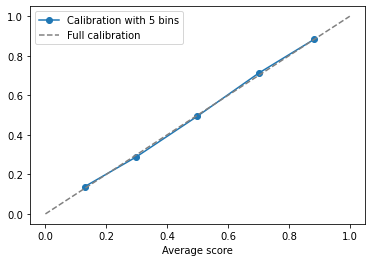

In [13]:
calibration.plot(x='Average score', y='Fraction of positives', label='Calibration with 5 bins', marker='o')
plt.plot([0,1], linestyle='--', color='gray', label='Full calibration')
plt.legend()
plt.show()

We see that the logistic regression model is very well calibrated (at least at the 5-bin scale we are looking at). The curve is relatively close to the 45 degree line.

The function below does both methods:

In [14]:
def calib_curve(y_true, y_probs, n_bins=10, method='quantile'):
    
    assert method in ['quantile', 'uniform'], "Unrecognized method"
    
    predictions = pd.DataFrame({
        'label': y_true,
        'scores': y_probs,
        })
    
    predictions = predictions.sort_values('scores')
    
    if method == 'quantile':
        quantiles = [predictions['scores'].quantile(q) for q in np.linspace(0, 1, n_bins+1)] 
        predictions['bins'] = pd.cut(predictions['scores'], quantiles)

    else:
        bins=np.linspace(0, 1, n_bins+1) 
        predictions['bins'] = pd.cut(predictions['scores'], bins)
        
    # we can now aggregate: average y=1 per chunk and average score per chunk
    calibration = predictions.groupby('bins').mean().reset_index(drop=True)
    calibration.columns = ['Fraction of positives', 'Average score']
    
    return calibration

Let's use both methods and compare to the `sklearn` native method:

In [15]:
n_bins = 10
quantile_calibration = calib_curve(y_test, y_probs, n_bins=n_bins, method='quantile')
uniform_calibration = calib_curve(y_test, y_probs, n_bins=n_bins, method='uniform')

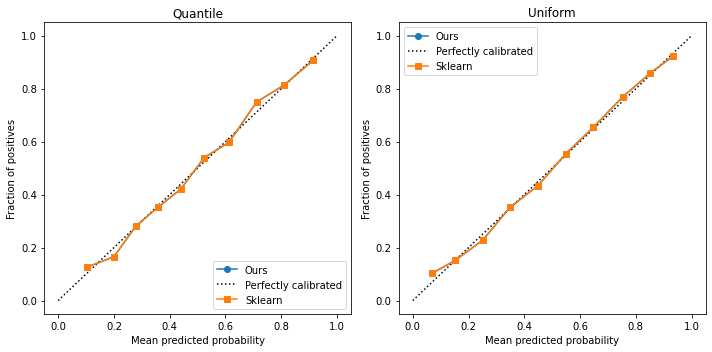

In [16]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# Quantile calibration
ax[0].plot(quantile_calibration["Average score"], quantile_calibration["Fraction of positives"], label='Ours', marker='o')
CalibrationDisplay.from_predictions(y_test,
                                   y_probs,
                                   n_bins=n_bins,
                                   ax=ax[0],
                                   name='Sklearn',
                                   strategy='quantile')

# Uniform calibration
ax[1].plot(uniform_calibration["Average score"], uniform_calibration["Fraction of positives"], label='Ours', marker='o')
CalibrationDisplay.from_predictions(y_test,
                                   y_probs,
                                   n_bins=n_bins,
                                   ax=ax[1],
                                   name='Sklearn',
                                   strategy='uniform')

ax[0].set_title("Quantile")
ax[1].set_title("Uniform")
plt.legend()
plt.tight_layout()
plt.show()

As we can see, our curves are identical. Scikit-learn uses the same logic to build their curves. We can happily use their library. However, sometimes we will need to access the proportion of points in each bin; for that, we also create the function below:

In [17]:
from sklearn.calibration import calibration_curve

def calib_curve_probs(y_true, y_probs, n_bins=10, method='uniform'):
    
    assert method in ['quantile', 'uniform'], "Unrecognized method"
    
    predictions = pd.DataFrame({
        'label': y_true,
        'scores': y_probs,
        })
    
    predictions = predictions.sort_values('scores')
    
    if method == 'quantile':
        quantiles = [predictions['scores'].quantile(q) for q in np.linspace(0, 1, n_bins+1)] 
        predictions['bins'] = pd.cut(predictions['scores'], quantiles)

    else:
        bins=np.linspace(0, 1, n_bins+1) 
        predictions['bins'] = pd.cut(predictions['scores'], bins)
        
    # we can now aggregate: average y=1 per chunk and average score per chunk
    calibration = predictions.groupby('bins').mean().reset_index(drop=True)
    calibration.columns = ['Fraction of positives', 'Average score']
    
    x, y = calibration['Average score'], calibration['Fraction of positives']
    p = predictions.groupby('bins').\
                   apply(lambda x: len(x)).\
                   values
    p = p/len(y_true)
    
    return x, y, p

In [18]:
def plot_calibration_curve(y_true, y_probs, n_bins=10, method='uniform', ax=None, legend=None):
    x, y, p = calib_curve_probs(y_true, y_probs, n_bins=n_bins, method=method)

    p = p/p.max() + p.min()
    
    if ax is None:
        plt.scatter(x, y, s=100*p, marker='o', edgecolors='black')
        plt.plot(x,y, label=legend)
        plt.plot([0,1], linestyle='--', color='gray')
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
        if legend is not None:
            plt.legend()
    
    else:
        ax.scatter(x, y, s=100*p, marker='o', edgecolors='black')
        ax.plot(x,y, label=legend)
        ax.plot([0,1], linestyle='--', color='gray')
        ax.set_xlabel("Mean predicted probability")
        ax.set_ylabel("Fraction of positives")
        if legend is not None:
            ax.legend()


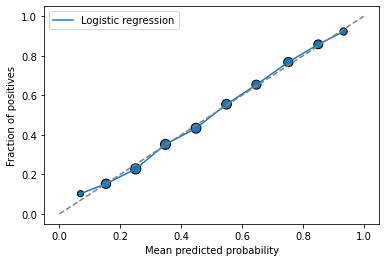

In [19]:
plot_calibration_curve(y_test, y_probs, legend='Logistic regression')

This plot includes the amount of points in each bin in the marker size.

### How to interpret a reliability plot?

Consider the plot on the right, for simplicity, and look at the y axis. 
* For small probabilities (until around 0.25), our model is too "optimistic": it outputs higher scores than it should
* This behavior is the same for high probabilities (above 0.60)
* It is opposite for intermediate probabilities (between 0.3 and 0.6), for which the model is actually pessimistic: the predicted scores are smaller than the corresponding probabilities

### How to choose the number of bins?

There is a trade-off here:
* If there are too many bins, each bin will contain few points. The mean score inside will be noisy
* If there are too little bins, each will comprehend a large range of scores; the mean will be precise but the variance. will be high. We also won't have enough points to assess the calibration of the curve

Below we display examples with increasing number of bins:

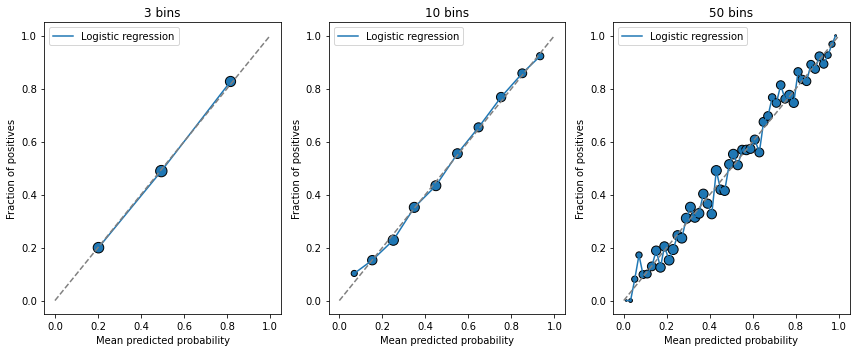

In [20]:
fig, ax = plt.subplots(ncols=3, figsize=(12,5))
for n, axx in zip([3, 10, 50], ax):
    plot_calibration_curve(y_test, y_probs, n_bins=n, ax=axx, legend='Logistic regression')
    axx.set_title(f"{n} bins")
    
plt.tight_layout()
plt.show()

## Metrics for assessing model reliability

In what follows, we will use our three pre-trained models to study model calibration metrics:

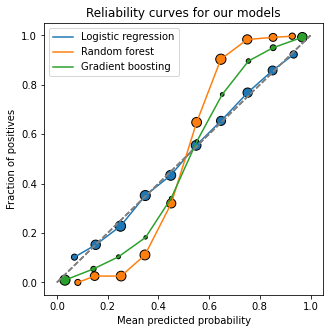

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
for model, name in zip([lr, rf, gb], ["Logistic regression", "Random forest", "Gradient boosting"]):
    plot_calibration_curve(y_test, model.predict_proba(X_test)[:,1], legend=name)
                                       
ax.set_title("Reliability curves for our models")
plt.show()

### The Brier (skill) score

A commonly used metric to analyze model reliability is the **Brier loss**: given a dataset $\{x_i, y_i\}_{i\in 1:N}$ and predicted scores $\{s_i = f(x_i)\}_{i\in 1:N}$, the Brier score is

$$\boxed{\mathrm{BS} = \frac{1}{N}\sum_{i=1}^N (s_i - y_i)^2}$$

ie. the mean squared error applied directly to probabilities. A well calibrated-model will have low Brier score.

> This is an estimator of the theoretical quantity $\displaystyle \mathbb E[(f(X) - Y)^2]$.

How much is low, though? Especially in imbalanced classification, one might argue that predicting all probabilities to be zero could yield a low benchmark to the Brier score. Because of that, we rather propose to use the following:

**Brier Skill Score**. Let 

$$\bar y = \frac{1}{N} \sum_{i=1}^N y_i,\qquad y_i \in \{0,1\}$$

be the average observed frequency of the positive class (which we assume to be the minority class as well). Define a baseline Brier score as

$$\mathrm{BS_{baseline}} = \frac{1}{N}\sum_{i=1}^N (\hat y - y_i)^2.$$

Then, the Brier Skill Score (BSS) is defined as

$$\boxed{\mathrm{BSS} = 1 - \mathrm{\frac{BS}{BS_{baseline}}}}$$

A **higher BSS** indicates a better model. In fact, we can think of BSS as analogous to $R$ squared in regression analysis.

In [22]:
def brier_skill_score(y_true, y_pred):
    
    from sklearn.metrics import brier_score_loss
    
    y_bar = y_true.mean() * np.ones_like(y_true)
    
    bs_baseline = brier_score_loss(y_true, y_bar)
    bs = brier_score_loss(y_true, y_pred)
    
    return 1 - bs/bs_baseline

In [23]:
print("Brier skill score comparison (the higher, the better): ")

for model in [lr, rf, gb]:

    model_name = type(model).__name__
    
    y_probs = model.predict_proba(X_test)[:,1]
    bss= brier_skill_score(y_test, y_probs)
    
    print(f"{model_name}\t {round(100*bss, 1)}%")

Brier skill score comparison (the higher, the better): 
LogisticRegression	 26.6%
RandomForestClassifier	 52.6%
HistGradientBoostingClassifier	 79.0%


This shows that not only do our gradient boosting model perform better, but it is better calibrated from a Brier score point of view.

**However!** In this view, Random Forest seems to be much better calibrated than Logistic Regression; from a visual inspection of the calibration curves, that doesn't seem to be the case. What is happening?

#### Is the Brier score sufficient?

Not really. It is a good indication of overall calibration, but it is also "contaminated" by raw model performance: a better model (from a ROC AUC point a view) will, on average, have a higher Brier score by default. 

A schematic view of this fact is:

$$\boxed{\mathrm{Brier \sim Calibration + Performance}}$$

> Proof (optional): this decomposition supposes that the scores can only take values on a finite set $\{S_1,\ldots,S_K\}$, ie. in bins. We can then write
$$\mathrm{BS} = \frac 1N \sum_{i=1}^N(s_i - y_i)^2 = \frac 1N \sum_{k=1}^K \sum_{i: s_i = S_K} (S_k - y_i)^2$$
For a fixed value $k$, there are $n_k$ instances, out of which there are $o_k$ where $y_i=1$. We can expand and then complete the square:
$$
\begin{align}
\\
\sum_{i: s_i = S_k} (S_k - y_i)^2  &= \sum_{i: s_i = S_k} (S_k^2 - 2 S_k y_i + y_i^2)\\
&= n_k S_k^2 - 2 S_k \sum_{i: s_i = S_k} y_i + \sum_{i: s_i = S_k} y_i^2\\
&= n_k S_k^2 - 2 S_k o_k + o_k \\
&= n_k \left(S_k^2 - 2 S_k \frac{o_k}{n_k} \right) + o_k\\
&= n_k \left[S_k^2 - 2 S_k \frac{o_k}{n_k} + \left( \frac{o_k}{n_k} \right)^2\right] + o_k - \frac{o_k^2}{n_k}\\
&= n_k \left(S_k - \frac{o_k}{n_k} \right)^2 + n_k \frac{o_k}{n_k} \left(1- \frac{o_k}{n_k} \right)\\
&\equiv n_k (S_k - \bar o_k)^2 + n_k \bar o_k (1-\bar o_k)\\
\end{align}
$$ 
where we defined $\bar o_k = o_k/n_k$ as the bin-wise event frequency. Then, we can write the Brier score as
$$\mathrm{BS} = \sum_{k=1}^K \frac{n_k}{N} (S_k - \bar o_k)^2 + \sum_{k=1}^K \frac{n_k}{N} \bar o_k (1-\bar o_k)$$ 
The first term measures how much the empirical frequency of events $\bar o_k$ compares to the score bin $S_k$. For a perfectly calibrated model, they will be equal and the first term is zero - this is the calibration term. The second one is a Gini impurity-like quantity.

TODO: need to understand this last term and how exactly it is connected to performance

Because of this, we need to be carefully with using the Brier score alone to measure calibration. A high ROC AUC will affect this assessment.

### Calibration spread measures

Looking at the calibration curves, one might be tempted to use them directly to measure calibration quality. This can be achieved by looking at the overall spread around the optimal calibration line, the 45 degree diagonal.

Given a point $(x, y)$ (where $x$ here is a shorthand for the predicted probability of a bin, and $y$ is a shorthand for the actual probability of the bin), it is easy to show that its distance to the diagonal (ie. the length of the line passing through $(x,y)$ which is orthogonal to the diagonal) is $d(x,y) = |x-y|/\sqrt{2}$.

Now, if we build the calibration curve as $\{x_b, y_b\}_{b \in 1:B}$ where $B$ is the total amount of bins,  we consider the spread as the (square root of the) average sum of squares of these distances:

$$S[B] = \left[\frac 1B \sum_{b=1}^B \frac{(x_b - y_b)^2}{2}\right]^{1/2} $$

But notice that this quantity is basically the root mean squared error of predicted and actual probabilities per bin: $S = \mathrm{RMSE}/\sqrt{2}$. Thus, we can just forget the $\sqrt{2}$ factor and **define the spread as the RMSE between true and predicted probabilities per bin**:

$$ \boxed{S[B] = \left[\frac 1B \sum_{b=1}^B (x_b - y_b)^2\right]^{1/2}}$$


But, how many bins to choose? We use a simple program: fix a minimum number of points you want to have inside a bin, $N_\mathrm{min}$; this limits the maximum amount of bins to

$$B_\mathrm{max} = \left\lfloor \frac{N}{N_\mathrm{min}} \right\rfloor$$

Also fix a minimum number of bins, say $B_\mathrm{min} = 5$. Then, just average:

$$\boxed{\bar S = \frac{1}{B_\mathrm{max} - B_\mathrm{min}} \sum_{B = B_\mathrm{min}}^{B_\mathrm{max}} S[B]}$$

This is implemented below:

In [24]:
def spread_calibration(y_true, y_pred, min_samples_per_bin=100, initial_bins=5):

    from sklearn.calibration import calibration_curve
    from sklearn.metrics import mean_squared_error

    n = len(y_test)
    n_max = int(n/min_samples_per_bin)
                           
    results = []
    for i in range(initial_bins, n_max+1):
        p_true, p_pred = calibration_curve(y_test, y_probs, n_bins=i, strategy='uniform')
        rmse = np.sqrt(mean_squared_error(p_pred, p_true))
        results.append(rmse)
    
    return np.mean(results)

In [25]:
print("Spread comparison (the lower, the better): ")
for model in [lr, rf, gb]:

    model_name = type(model).__name__
    
    y_probs = model.predict_proba(X_test)[:,1]
    rmse = spread_calibration(y_test, y_probs)
    
    print(f"{model_name}\t {round(100*rmse,1 )}%")

Spread comparison (the lower, the better): 
LogisticRegression	 3.1%
RandomForestClassifier	 17.7%
HistGradientBoostingClassifier	 11.2%


We see here that logistic regression is now the best - a totally different conclusion than we would have obtained looking at the Brier score alone.

### Expected Calibration Error (ECE)

A similar metric seen in the literature (https://people.cs.pitt.edu/~milos/research/AAAI_Calibration.pdf) is the ECE and its cousin, the Maximum Calibration Error (MCE):

$$\mathrm{ECE} = \sum_{b=1}^B p_b |x_b - y_b|,\qquad \mathrm{MCE} = \max_{b \in \{1,\ldots,B\}} |x_b-y_b|$$

where $p_b$ is the fraction of points falling in bin $b$. Note that the total bin count $B$ is fixed here, and taken to be $B=10$. Note that the ECE calculation using the `quantile` strategy simply yields the $L1$ error, analogous to our root-mean-squared one from the previous section.

In [26]:
def ece(y_true, y_probs, n_bins=10, method='uniform'):
    x, y, p = calib_curve_probs(y_true, y_probs, n_bins=n_bins, method=method)
    return np.sum(p*np.abs(x - y))

def mce(y_true, y_probs, n_bins=10, method='uniform'):
    x, y, _ = calib_curve_probs(y_true, y_probs, n_bins=n_bins, method=method)
    return np.max(np.abs(x-y))

In [27]:
print("ECE comparison (the lower, the better): ")
for model in [lr, rf, gb]:

    model_name = type(model).__name__
    
    y_probs = model.predict_proba(X_test)[:,1]
    error = ece(y_test, y_probs)
    
    print(f"{model_name}\t {round(100*error,1 )}%")

print('-----')

print("MCE comparison (the lower, the better): ")
for model in [lr, rf, gb]:

    model_name = type(model).__name__
    
    y_probs = model.predict_proba(X_test)[:,1]
    error = mce(y_test, y_probs)
    
    print(f"{model_name}\t {round(100*error,1 )}%")

ECE comparison (the lower, the better): 
LogisticRegression	 1.1%
RandomForestClassifier	 17.5%
HistGradientBoostingClassifier	 5.7%
-----
MCE comparison (the lower, the better): 
LogisticRegression	 3.3%
RandomForestClassifier	 25.7%
HistGradientBoostingClassifier	 16.7%


Both give qualitative results which are similar to the spread analysis we did before.

## Summary: running reliability analysis

* First, decide if reliability / calibration is important to you or not
  * If you just care about ordering points correctly, then you do not need calibrated models
  * If you do care about the actual probabilities, then you need calibration
* For each model you want to test:
  * Calculate their calibration curves - run a visual analysis
  * Calculate Brier Skill Score; values greater than 0.50 tend to indicate good calibration
  * Calculate the ECE (or spread); values smaller than 0.10 tend to indicate good calibration

TODO: we need to verify these last claims!!

TODO: stratified Brier score? what happens to all this in the imbalanced case? 
https://www.researchgate.net/publication/319617533_A_simple_plug-in_bagging_ensemble_based_on_threshold-moving_for_classifying_binary_and_multiclass_imbalanced_data/link/59c21da7aca272295a0d9cc1/download

Should we use Brier for training?
https://stats.stackexchange.com/questions/489106/brier-score-and-extreme-class-imbalance


Brier = AUC + calibration
https://en.wikipedia.org/wiki/Brier_score#Two-component_decomposition
http://www.icml-2011.org/papers/366_icmlpaper.pdf

Brier interpretation
https://stats.stackexchange.com/questions/489106/brier-score-and-extreme-class-imbalance
https://ore.exeter.ac.uk/repository/bitstream/handle/10871/34847/revision2.pdf;jsessionid=E6147655F7CD758C9610733CC2FD785A?sequence=1

---

# Model calibration part II - calibrating outputs

So far, we have studied how to assess and measure reliability in pre-trained models. In this section, we go one step further and discuss how to improve their reliability via a **calibration procedure**.

There are essentially two ways to calibrate a model:
1. Take a pre-trained model and use a 1-1 function to "scale up and down" its outputs, so that it better reflects the inherent probabilities.
2. Train both model and the "calibrator" together from the beginning.

We will discuss these two sequentially.

### But first: should you be calibrating?

Google says you shouldn't: https://towardsdatascience.com/why-calibrators-part-1-of-the-series-on-probability-calibration-9110831c6bde. Their points:
* Calibration sweeps structural issues with yoour data/model under the rug
* Calibration adds a new layer of complexity to your model, which needs to be maintained

They are not wrong. It is true that bad model reliability might just be a downstream symptom of other issues, such as bad or incomplete data/features, bias, and overly strong regularization. These need to be dealt with separately.

But it is also true that in real-life applications there might be time/money/availability constraints which hinder you from improving your data. In that case, being able to count on a model having interpretable probabilistic outputs is crucial, and we cannot avoid calibration. 

### Calibrating pre-trained models

References:
* [1] Seminal paper: https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf
* [2] Bayesian binning (BBQ): https://people.cs.pitt.edu/~milos/research/AAAI_Calibration.pdf

The basic approach to calibrating pre-trained models is to apply a **post-processing function** with nice properties which maps predicted scores to newer scores which are closer to actual probabilities. More specifically, if $s \in [0,1]$ is a predicted score, we want to find a function $\phi:  [0,1] \to [0,1]$ such that $\phi(s)$ is better calibrated than $s$ itself.

There are two main categories of this "post-processing" calibration:

* Parametric approach (Platt, 1999) - usually with a **logistic curve**
* Non-parametric:
  * Binning (quantile method)
  * **Isotonic-regression**, via the PAV algorithm.
  * Others, such as BBQ (Bayesian Binning into Quantiles)

Methods in boldface are available in `sklearn` via the `CalibratedClassifierCV` method.

### Digression: what is an isotonic regression?

Consider simple regression: we have a data set $\{x_i, y_i\}_{i\in 1:N}$ where both $x_i$'s and $y_i$'s are real numbers. Our goal is to find a simple function $f(x)$ which fits the data well, **which is also monotonic**. 

> A function $f$ is said to be monotonic if it is either non-increasing or non-decreasing. For instance, the function $f(x) = x^3$ is monotonic over $\mathbb R$ since it is non-decreasing (being in fact purely increasing: $y > x \Rightarrow f(y) > f(x)$.

This can be written as a quadratic optimization problem. First, with no loss of generality assume that $x_i$'s are ordered, such that $x_{i+1} \geq x_i$. 

The problem is then to find $f$ such that $$\sum_{i=1}^N (y_i - f(x_i))^2$$ is minimal, subject to $f(x_{i+1}) \geq f(x_i)$ for all $i$.

This can be solved via the so-called PAV algorithm. Below, we show an example:

In [28]:
# some point scatter
x0 = 5*np.abs(np.random.randn(200))
x1 = np.sqrt(x0) + np.random.randn(200)

We now fit an isotonic regression:

In [29]:
from sklearn.isotonic import IsotonicRegression

iso = IsotonicRegression(increasing=True)
iso.fit(x0,x1)

x0_ = np.linspace(x0.min(), x0.max())
x1_ = iso.predict(x0_)

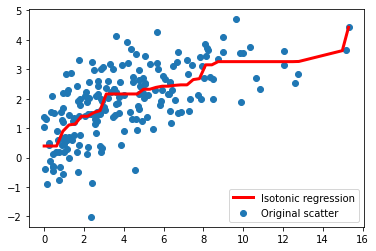

In [30]:
plt.scatter(x0, x1, label='Original scatter')
plt.plot(x0_, x1_, lw=3, color='red', label='Isotonic regression')
plt.legend()
plt.show()

As you can see, the isotonic regression fits a piecewise monotonic function over the data!

### Best practices for calibration

The points below were adapted from [1] https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf

* Always **separate a (stratified) calibration dataset** (if using `CalibratedClassifierCV` this is already done for you)
* **Ensure your calibration dataset / CV folds are large enough**; ideally with a 1000-2000 or more entries
* If using neural networks or logistic regression, most likely calibration won't help much. Reliability metrics will either stay the same or even get worse.
* **Tree-based models and SVM will benefit from calibration**. Their reliability curves will most likely have an S-shape; naive Bayes will also benefit, with a reliability curve initially looking like an inverted S-shape.
* Use **isotonic regression**.

Below, we train a few different models and calibrate them using `sklearn`.

In [31]:
def train_calib_test_split(X, y, train_size=0.5, calib_size=0.25, test_size=0.25, random_state=1):

    from sklearn.model_selection import train_test_split
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size,
                                                                stratify=y, random_state=random_state)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=calib_size/(train_size+calib_size), 
                                                      stratify=y_train_val, random_state=random_state+12)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [32]:
## Making data - same as before

X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10)

In [33]:
X_train, X_calib, X_test, y_train, y_calib, y_test = train_calib_test_split(X, y,
                                                                     train_size=0.6,
                                                                     calib_size=0.15,
                                                                     test_size=0.25,
                                                                     random_state=42)

In [34]:
## Train models on TRAINING set

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

models = [
    HistGradientBoostingClassifier(max_depth=5, random_state=1),
    RandomForestClassifier(max_depth=5, random_state=2),
    LogisticRegression(),
    GaussianNB()
]

for model in models:
    model.fit(X_train, y_train)

In [35]:
# Calibrate models on VALIDATION set
calib_models = []
for model in models:
    calibrator = CalibratedClassifierCV(base_estimator=model, cv='prefit', method='isotonic')
    calibrator.fit(X_calib, y_calib)
    calib_models.append(calibrator)

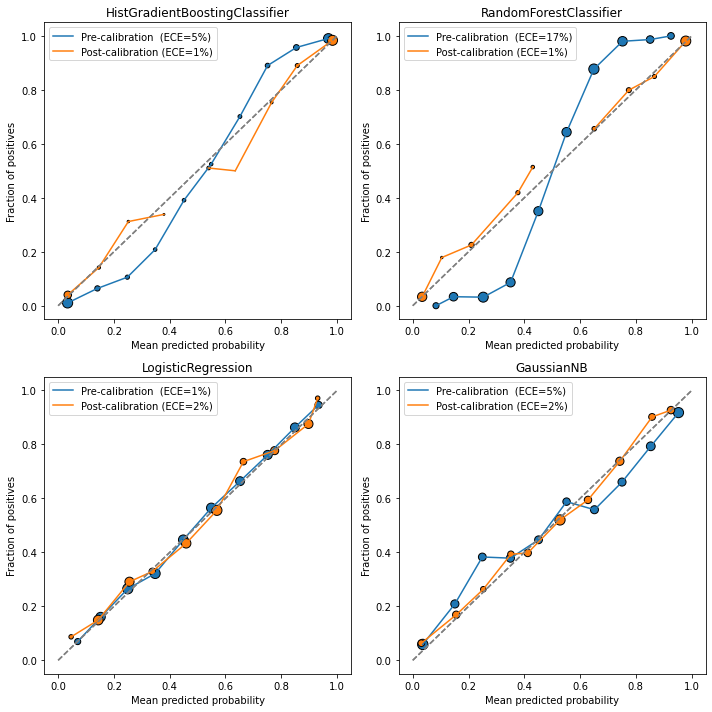

In [36]:
# Assess performance on TEST set
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()

for axx, model, calibrator in zip(ax, models, calib_models):
    
    model_name = type(model).__name__

    # base model
    y_probs = model.predict_proba(X_test)[:,1]
    error_base = ece(y_test, y_probs)
    plot_calibration_curve(y_test, y_probs, n_bins=10, ax=axx, 
                           legend=f'Pre-calibration  (ECE={round(100*error_base)}%)')
    
    # calibrated model
    y_probs = calibrator.predict_proba(X_test)[:,1]
    error_calib = ece(y_test, y_probs)
    plot_calibration_curve(y_test, y_probs, n_bins=10, ax=axx, 
                           legend=f'Post-calibration (ECE={round(100*error_calib)}%)')
        
    axx.set_title(model_name) 

plt.tight_layout()
plt.show()

In all cases except Logistic Regression, the calibrated models performed better in terms of ECE (and even in the logistic case, the ECE values are close).

Also notice the characteristic S-shape in the Random Forest / Gradient Boosting reliability plots, and the inverse S-shape for Gaussian Naive Bayes.

Finally, looking at the marker sizes, we see that 

## Useful functions

Below, we make available a function to get a pre-trained model and display its **performance & calibration** metrics.

In [37]:
def classification_model_report(model, X_calib, y_calib, X_test, y_test):
    
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
    from sklearn.calibration import CalibratedClassifierCV
    
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    model_name = type(model).__name__

    plt.suptitle(model_name)
    
    y_probs = model.predict_proba(X_test)[:,1]
    
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    
    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_probs)
    ap = average_precision_score(y_test, y_probs)
    
    
    ax[0].plot(fpr, tpr, label='ROC base (AUC={0:.2f})'.format(auc)); ax[0].set_title("ROC curve")
    ax[0].legend(); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
    
    ax[1].plot(rec, prec, label='PR base (AP={0:.2f})'.format(ap)); ax[1].set_title("Precision-Recall curve")
    ax[1].legend(); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
    
    # Calibration
    error = ece(y_test, y_probs) 
    plot_calibration_curve(y_test, y_probs, n_bins=10, ax=ax[2], 
                           legend=f'Pre-calibration  (ECE={round(100*error,1)}%)')


    calibrator = CalibratedClassifierCV(base_estimator=model, cv='prefit', method='isotonic')
    calibrator.fit(X_calib, y_calib)
    y_probs = calibrator.predict_proba(X_test)[:,1]
    error = ece(y_test, y_probs)
    
    plot_calibration_curve(y_test, y_probs, n_bins=10, ax=ax[2], 
                                        legend=f'Post-calibration  (ECE={round(100*error,1)}%)')

    ax[2].legend(); ax[2].set_title("Reliability curve")
    plt.tight_layout()
    plt.show()
    
    return calibrator

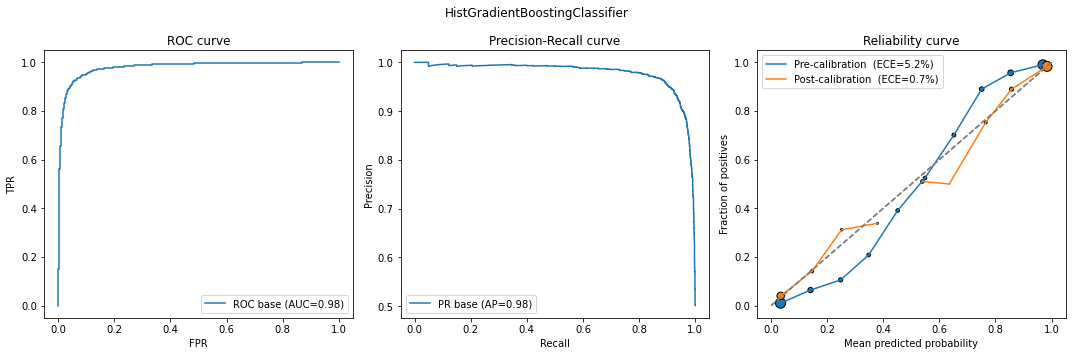

In [38]:
# Example: on gradient boosting model vs. random forest
calib_model = classification_model_report(models[0], X_calib, y_calib, X_test, y_test)

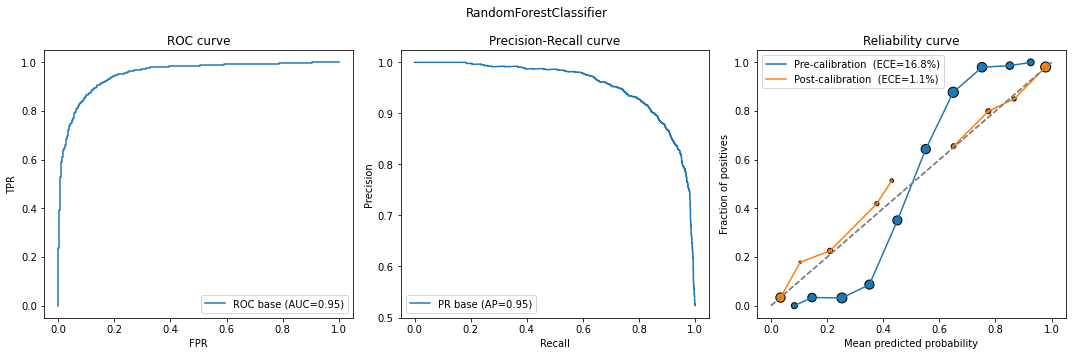

In [39]:
calib_model = classification_model_report(models[1], X_calib, y_calib, X_test, y_test)

# What about class imbalance?

Ref:
* [1] https://ieeexplore.ieee.org/abstract/document/6413859 - Imbalanced calibration

* Using sklearn: https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/

Intuitively, higher class imbalance means

(1) less trustworthy binning of points, with less points of the minority class per bin 

(2) more concentration of scores in very high or very low values 

(3) a need to use metrics which are sensitive to class imbalance

As [1] points out, 

> Class probability estimates attained via supervised learning in imbalanced scenarios **systematically underestimate the probabilities for minority class instances**, despite ostensibly good overall calibration

The key point here is that we are still getting bad estimates for minority class probabilities, **regardless of overall good calibration**. Again, [1] reiterates that: 

> Probability estimates for the minority instances in imbalanced datasets are unreliable, and methods for mitigating *class imbalance* for classification do not automatically fix *calibration*.

Starting from the conclusion:
* **Train the best model you can**. In many cases, using best practices for training models in imbalanced situations will be enough (we will see this below).
* **Try using regular calibration, but don't expect much of it**. This is a consequence of the argument above. Most likely, it will improve calibration for the majority class only.
* **Choose calibration approaches which are adapted to imbalanced scenarios**. We describe one of these below via bagging.


### A good calibration metric in imbalanced cases

Wallace & Dahabreh (2012) in [1] propose to study two instead of just one Brier score, stratifying by label:

$$\mathrm{BS}_1 = \frac{1}{N_1} \sum_{i: y_i = 1} (s_i - 1)^2$$
$$\mathrm{BS}_0 = \frac{1}{N_0} \sum_{i: y_i = 0} (s_i - 0)^2$$

where $N_i$ is the total of entries in each class. Arguably, in the imbalanced case we care more about $\mathrm{BS}_1$, and it is the metric that should be included in analyses.

The function below calculates both **stratified Brier scores**:

In [40]:
def stratified_brier_score(y_true, y_probs):
    dic= {
        1: ((y_probs[y_true==1] - 1)**2).mean(),
        0: ((y_probs[y_true==0])**2).mean()
    }
    
    return pd.DataFrame(dic, index=['Brier'])

We will test this function in the next section.

### A two-step approach to calibrating in imbalanced cases

Reference [1] suggests we use two sequential approaches to solve for class imbalance:
> Obs: here, we assume a **pre-trained model**! Therefore, techniques to solve for class imbalance in training can be used at will; this discussion applies to the calibration process only.
1. **Random undersampling** of the majority class will equilibrate class balance; however, it will introduce a bias due to the random nature of the undersampling
2. **Bagging** solves the bias issue by creating various boostrap samples of the undersampled data and calibrating to each one, then averaging the results.

We will call this the **underbagging approach** (Wallace-Dahabreh approach) for simplicity.

An extra step that can be done with `sklearn` is to change `class_weights` (when available); this is similar to undersampling in which positive samples will have a higher weight.

Let's run this procedure for a toy dataset. Consider the same data we've been using so far, but with a high imbalance rate:

In [41]:
X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10,
                           weights=(0.99,)) ## 99 to 1 proportion between classes

We split into a stratified train/calibration/test base. The train data will be used to train a model (however we like); we will then modify the calibration data to solve for imbalance. All results will be tested in the test data.

In [42]:
X_train, X_calib, X_test, y_train, y_calib, y_test = train_calib_test_split(X, y,
                                                                     train_size=0.5,
                                                                     calib_size=0.3,
                                                                     test_size=0.2,
                                                                     random_state=21)

#### a) Naive approach - model NOT optimized for imbalanced data

For a second, ignore the recommended underbagging procedure and see what we get with a naive usage of the methods so far:

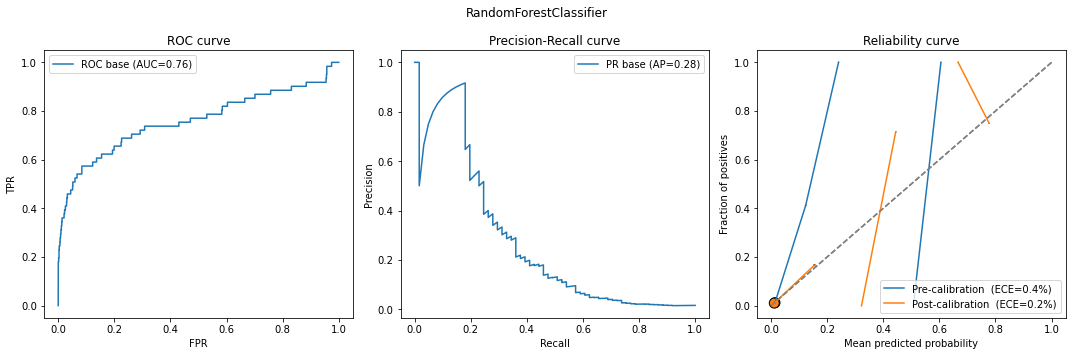

In [43]:
model = RandomForestClassifier(max_depth=5, random_state=1)
                               # class_weight="balanced_subsample") # we will turn this on later!
model.fit(X_train, y_train)
model_calib = classification_model_report(model, X_calib, y_calib, X_test, y_test)

Something is weird. Why are the **ECEs so low** when the curves (both pre and post calibration) look so bad? The answer lies in the definition of ECE. Recall that it is the *weighted* sum of $|x-y|$ for each bin. Look at the bubble size: basically all points are thrown to zero! We can see that more clearly via a histogram:

In [44]:
y_probs = model.predict_proba(X_test)[:,1]

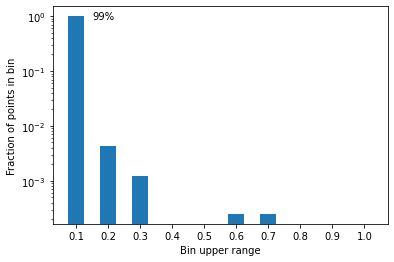

In [45]:
x, y, p = calib_curve_probs(y_test, y_probs, n_bins=10)
plt.bar(np.arange(0.1, 1.1, 0.1), p, width=0.05)
plt.yscale('log'); plt.ylabel("Fraction of points in bin")
plt.xticks(np.arange(0.1, 1.1, 0.1)); plt.xlabel("Bin upper range")
plt.text(0.15, p[0]*0.90, f"{round(p[0]*100)}%")
plt.show()

More than 99% of points have a score between 0 and 10%; that makes sense, since the data is heavily imbalanced, so most points have very little chance of being in the positive class.

Because of that, using ECE won't help much, and we need other metrics.

#### But does naive calibration help with the stratified Brier score?

In [46]:
print("Original model")
stratified_brier_score(
    y_true=y_test, 
    y_probs=model.predict_proba(X_test)[:,1]
)

Original model


,1,0
Brier,0.879947,0.000352


In [47]:
print("Calibrated model")
stratified_brier_score(
    y_true=y_test, 
    y_probs=model_calib.predict_proba(X_test)[:,1]
)

Calibrated model


,1,0
Brier,0.785159,0.000754


There was indeed an improvement on the stratified Brier score for class 1 (10 points), despite a worsening for class 0.

#### Trying the Wallace-Dahabreh underbagging approach

Let us then use the undersampling+bagging procedure. We build a function to get boostrap samples of the calibration database: 

In [49]:
def undersample_boostrap(X_calib, y_calib, target_balance=0.5):
    
    # separate positive and negative classes
    X1 = X_calib[y_calib==1]; n1 = len(X1)
    X0 = X_calib[y_calib==0]; n0 = len(X0)

    # undersample X0
    bs_indices = np.random.choice(np.arange(0,n0), 
                            size=int(n1*(1-target_balance)/target_balance),
                            replace=True)

    X0_u = X0[bs_indices]; n0_u = len(X0_u)

    # rebuild
    X_calib_u = np.concatenate([X1, X0_u])
    y_calib_u = np.concatenate([np.ones(n1), np.zeros(n0_u)])

    # shuffle - or should it be bootstrap ?
    indices = np.arange(0, len(X_calib_u))
    np.random.shuffle(indices)

    X_calib_u = X_calib_u[indices]
    y_calib_u = y_calib_u[indices]
    
    return X_calib_u, y_calib_u

In [50]:
class BaggedCalibratedPredictor:
    
    def __init__(self,
                 pretrained_model,
                 target_balance=0.1,
                 bootstrap_samples=100,
                ):
        self.model = pretrained_model
        self.target_balance = target_balance
        self.bootstrap_samples = bootstrap_samples
        
        self.trained = False
        
    def calibrate(self, X_calib, y_calib):
        
        calibrator_list = []
        for _ in range(self.bootstrap_samples):
            calibrator = CalibratedClassifierCV(base_estimator=self.model,
                                                cv='prefit', 
                                                method='isotonic')

            X_boot, y_boot = undersample_boostrap(X_calib, y_calib, 
                                                  target_balance=self.target_balance)
            calibrator.fit(X_boot, y_boot)
            calibrator_list.append(calibrator)

        self.calibrator_list = calibrator_list
        self.trained = True
    
    def predict_proba(self, X):
        
        if not self.trained:
            raise Exception("Calibrator not calibrated yet")
        
        results = []
        for calibrator in self.calibrator_list:
            results.append(calibrator.predict_proba(X))
        
        mean_pred = np.array(results).mean(axis=0)
        return mean_pred

In [51]:
bagged_calib = BaggedCalibratedPredictor(model, 
                                  target_balance=0.3, bootstrap_samples=400)
bagged_calib.calibrate(X_calib, y_calib)

In [52]:
stratified_brier_score(
    y_true=y_test, 
    y_probs=bagged_calib.predict_proba(X_test)[:,1]
)

,1,0
Brier,0.333249,0.071978


So we see our strategy worked. We did improve significantly the calibration for the positive class by almost three times; however, we did so by significantly killing the calibration for class 0.

Summarizing results:

In [65]:
# base model
df_base = stratified_brier_score(
    y_true=y_test, 
    y_probs=model.predict_proba(X_test)[:,1]
)

# simply calibrated model
df_cal = stratified_brier_score(
    y_true=y_test, 
    y_probs=model_calib.predict_proba(X_test)[:,1]
)

# undersample+bagged calibrated model
bagged_calib = BaggedCalibratedPredictor(model, 
                                  target_balance=0.3, bootstrap_samples=400)
bagged_calib.calibrate(X_calib, y_calib)

df_bagcal = stratified_brier_score(
    y_true=y_test, 
    y_probs=bagged_calib.predict_proba(X_test)[:,1]
)

# join everything together
res = pd.concat([df_base, df_cal, df_bagcal])
res.index = index=['Original', 'Simple', 'Underbagged']
print('Stratified Brier score comparison [bad base model]')
res

Stratified Brier score comparison [bad base model]


,1,0
Original,0.197718,0.207776
Simple,0.868591,0.001232
Bagged,0.354848,0.083588


#### b) Better approach - model suited for imbalanced data

Let us repeat the procedure above, but with a better random forest model (including class weights).

Specifically, we will compare:
* Original model 
* Simple calibration of original model
* Underbagging calibration of model

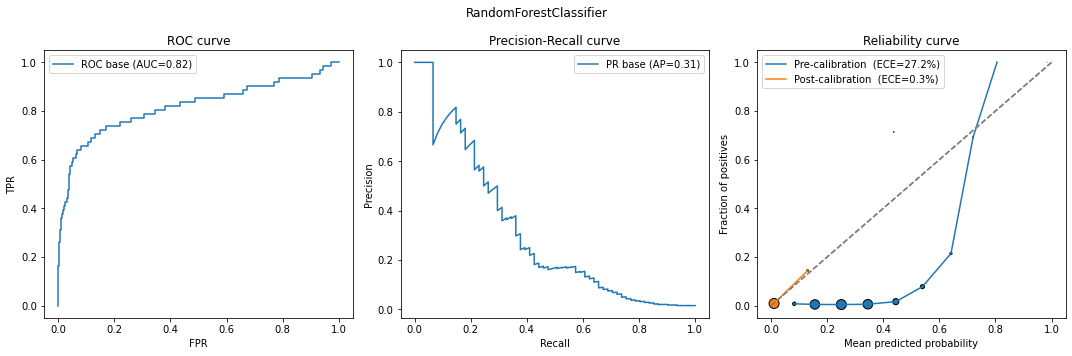

In [54]:
model = RandomForestClassifier(max_depth=5, random_state=1,
                               class_weight="balanced_subsample")
model.fit(X_train, y_train)
model_calib = classification_model_report(model, X_calib, y_calib, X_test, y_test)

In [55]:
# base model
df_base = stratified_brier_score(
    y_true=y_test, 
    y_probs=model.predict_proba(X_test)[:,1]
)

# simply calibrated model
df_cal = stratified_brier_score(
    y_true=y_test, 
    y_probs=model_calib.predict_proba(X_test)[:,1]
)

# undersampling+bagging calibrated model
bagged_calib = BaggedCalibratedPredictor(model, 
                                  target_balance=0.3, bootstrap_samples=400)
bagged_calib.calibrate(X_calib, y_calib)

df_bagcal = stratified_brier_score(
    y_true=y_test, 
    y_probs=bagged_calib.predict_proba(X_test)[:,1]
)

# join everything together
res = pd.concat([df_base, df_cal, df_bagcal])
res.index = index=['Original', 'Simple', 'Underbagged']
print('Stratified Brier score comparison [improved model]')
res

Stratified Brier score comparison [improved model]


,1,0
Original,0.283600,0.095445
Simple,0.781644,0.000783
Bagged,0.283778,0.069116


What do we see here? The original model is already pretty well-calibrated for both classes (although better for 0 than 1). Upon trying to run simple calibration, it destroys that - class 0 gets extremely well-calibrated, whereas class 1 gets much worse. Indeed, these new Brier scores are similar to those of the calibrated "naive" model with no weights. Finally, underbagging calibration yields similar results to those of the original model, showing that in this particular case there isn't much value in calibrating the model, but it doesn't hurt either.

Had we not used a better random forest model (with weights), the underbagging calibration process would have been our best shot (and indeed, its Brier score for both classes is similar to the final one we got here as well). Thus, it is a good idea to use this method especially if the trained model is not "smart" against imbalance.

### Same exercise, different model

The `HistGradientBoostingClassifier` model does not have an option to pass class weights, but we can specify sample weights during training.

We will choose sample weights to balance the odds:

In [56]:
positives = y_train.sum()
negatives = len(y_train) - positives
sample_weights = np.where(y_train == 1, negatives/positives, 1)

In [57]:
model = HistGradientBoostingClassifier(max_depth=5, random_state=1)
model.fit(X_train, y_train, sample_weight=sample_weights)

# calibrate model
model_calib = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
model_calib.fit(X_calib, y_calib);

In [60]:
# base model
df_base = stratified_brier_score(
    y_true=y_test, 
    y_probs=model.predict_proba(X_test)[:,1]
)

# simply calibrated model
df_cal = stratified_brier_score(
    y_true=y_test, 
    y_probs=model_calib.predict_proba(X_test)[:,1]
)

# bagged calibrated model
bagged_calib = BaggedCalibratedPredictor(model, 
                                  target_balance=0.3, bootstrap_samples=100)
bagged_calib.calibrate(X_calib, y_calib)

df_bagcal = stratified_brier_score(
    y_true=y_test, 
    y_probs=bagged_calib.predict_proba(X_test)[:,1]
)

# join everything together
res = pd.concat([df_base, df_cal, df_bagcal])
res.index = index=['Original', 'Simple', 'Underbagged']
print('Stratified Brier score comparison')
res

Stratified Brier score comparison


,1,0
Original,0.337104,0.026831
Simple,0.618758,0.001429
Bagged,0.248155,0.054920


This case exemplifies well how useful the underbagging calibration method can be. The original model had OK calibration for class 1, and a good one for class 0. Upon standard calibration, we get the usual trend: class 0 gets much better calibrated, whereas class 1 worsens. Finally, using bagged calibration, we improve the original calibration of class 1 while not too strongly worsening the calibration of class 0.

Finally, a good sanity check is to see if our metrics are still preserved:

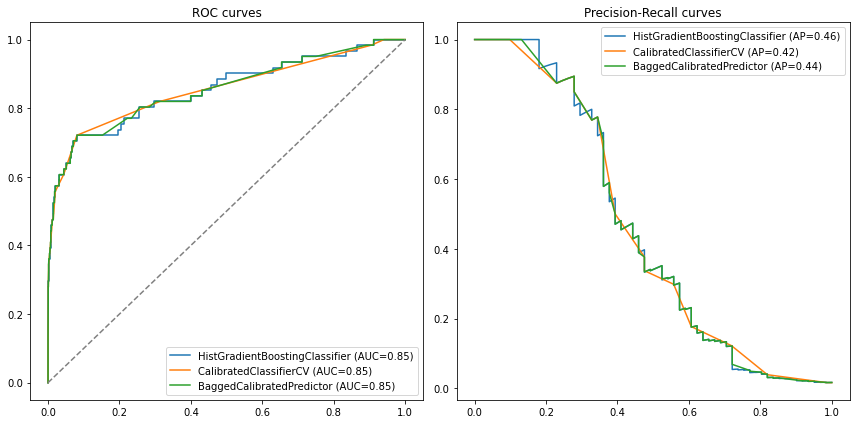

In [61]:
compare_models([model, model_calib, bagged_calib], X_test, y_test)

### Is the underbagging approach always the best?

No. The example below with a **Logistic Regression** proves it:

In [69]:
model = LogisticRegression(C=0.1, class_weight='balanced')
model.fit(X_train, y_train)

# calibrate model
model_calib = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
model_calib.fit(X_calib, y_calib);

# base model
df_base = stratified_brier_score(
    y_true=y_test, 
    y_probs=model.predict_proba(X_test)[:,1]
)

# simply calibrated model
df_cal = stratified_brier_score(
    y_true=y_test, 
    y_probs=model_calib.predict_proba(X_test)[:,1]
)

# bagged calibrated model
bagged_calib = BaggedCalibratedPredictor(model, 
                                  target_balance=0.3, bootstrap_samples=100)
bagged_calib.calibrate(X_calib, y_calib)

df_bagcal = stratified_brier_score(
    y_true=y_test, 
    y_probs=bagged_calib.predict_proba(X_test)[:,1]
)

# join everything together
res = pd.concat([df_base, df_cal, df_bagcal])
res.index = index=['Original', 'Simple', 'Underbagged']
print('Stratified Brier score comparison')
res

Stratified Brier score comparison


,1,0
Original,0.197709,0.207775
Simple,0.868663,0.001230
Underbagged,0.356661,0.083185


The original model had a better calibration for the minority class than the underbagged one! This shows that one must use this procedure carefully. Particularly for logistic regression, where we already are fitting probabilities, calibration might not yield great results.

# Recommendations

* First, decide if reliability / calibration is important to you or not
  * If you just care about ordering points correctly, then you do not need calibrated models
  * If you do care about the actual probabilities, then you need calibration


* If you have a *balanced* classification problem:
  * Reliability curves and ECE are the main tools to assess reliability
  * Standard model calibration might be enough, especially for tree-based models
  * Pre-fit `CalibratedClassifierCV` with isotonic regression is the way to go


* If you have an *imbalanced* problem:
  * Smartly training a model which deals well with imbalance (via its algorithm, `class_weight` or `sample_weights` parameters, etc) is crucial
  * Stratified Brier scores are your best choice of reliability metric
  * Undersampling+bagging calibration (also with isotonic regression) might be your best choice, especially for tree-based models. 


* General best practices to run a calibration procedure:
  * Always separate a (stratified) calibration dataset (or, if using  this is already done for you)
  * Ensure your calibration dataset / CV folds are large enough; ideally with a 1000-2000 or more entries
  * If using neural networks or logistic regression, most likely calibration won't help much. Reliability metrics will either stay the same or even get worse. Still, doesn't hurt to test
